## Branchwater output comparison
Branchwater x 14 spp that were in 99% of the pig gut metagenomes
Seem to be core spp. How predictive are they together or in combination that something is a pig, or pig related?

Have:
- Presence absence matrix with sample,species, 0/1
- df with for each sample what the host is 

In [285]:
import pandas as pd


In [286]:
df = pd.read_csv('../../2025-pig-binning-paper/250830-branchwater/251001_presence_absence.branchw.csv')
df2 = pd.read_csv('../../2025-pig-binning-paper/250830-branchwater/251001_merged.branchwater.csv')
#df2['assay_type'].value_counts()

In [287]:
df['metag_count'] = df.iloc[:, 1:].sum(axis=1)
df = df[df['metag_count'] != 0]


In [288]:
df['metag_count'].value_counts()

metag_count
1     43497
2     18473
3      8841
4      4260
14     2499
5      2279
13     1613
6      1413
12     1337
7      1070
11      966
8       938
9       872
10      867
Name: count, dtype: int64

In [289]:
df = df.merge(df2, on='acc', how='left')


In [290]:
df = df[df['assay_type'] == 'WGS']


In [291]:
df['organism'].value_counts()

organism
human gut metagenome        37643
gut metagenome               9216
metagenome                   7257
pig gut metagenome           5906
feces metagenome             3312
                            ...  
uncultured bacterium            1
human vaginal metagenome        1
Alistipes onderdonkii           1
Caenorhabditis elegans          1
seagrass metagenome             1
Name: count, Length: 197, dtype: int64

In [292]:
df = df[['metag_count', 'acc', 'organism']]

In [293]:
df = df[df['organism'].str.contains('metagenome', case=False, na=False)]


In [294]:
df.to_csv('../../2025-pig-binning-paper/250830-branchwater/251001_metagenome_assigned.csv')

In [266]:
import pandas as pd

# Keep only the columns we care about
df_sub = df[['metag_count', 'organism']]

# Drop rows where metag_count is 0, if needed
df_sub = df_sub[df_sub['metag_count'] != 0]

# Use pd.crosstab to get counts
df_pivot = pd.crosstab(df_sub['organism'], df_sub['metag_count']).reset_index()

# Optional: rename columns nicely
df_pivot.columns = ['organism'] + [str(col) for col in df_pivot.columns[1:]]


In [279]:
df


,metag_count,acc,organism
0,4,ERR11504361,human gut metagenome
1,3,ERR6170257,human gut metagenome
2,12,SRR13304098,soil metagenome
3,2,ERR11456590,human gut metagenome
4,4,ERR11478504,human gut metagenome
...,...,...,...
88919,1,ERR11491672,human gut metagenome
88920,1,ERR9669538,metagenome
88921,1,SRR12995962,feces metagenome
88923,1,SRR31101802,metagenome


In [268]:


category_map = {
    'human': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa'],
    'other_mammal': ['cow', 'bovine', 'bos','musculus', 'mouse', 'rat','canine', 'feline'],
    'poultry':['chicken', 'poultry', 'gallus'],
    'soil':['sediment', 'soil', 'sludge', 'wetland', 'bog'],
    'bioreactor': ['bioreactor'],
    'water':['water', 'marine']}


# Function to assign category based on keywords
def get_broad_cat(organism):
    for cat, keywords in category_map.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  # default if no keywords match


df_pivot['broad_cat'] = df_pivot['organism'].apply(get_broad_cat)
df_pivot.loc[df_pivot['organism'].str.lower() == 'metagenome', 'broad_cat'] = 'metagenome'
df_pivot.loc[df_pivot['organism'].str.lower() == 'gut metagenome', 'broad_cat'] = 'gut metagenome'
df_pivot.loc[df_pivot['organism'].str.lower() == 'feces metagenome', 'broad_cat'] = 'feces metagenome'


In [269]:
# Automatically select all numeric columns
numeric_cols = df_pivot.select_dtypes(include='number').columns.tolist()

# Group by broad_cat and sum numeric columns
df_grouped = df_pivot.groupby('broad_cat')[numeric_cols].sum().reset_index()


In [270]:
df_grouped

,broad_cat,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,bioreactor,23,19,4,4,4,6,3,4,4,3,1,2,9,23
1,feces metagenome,1367,650,366,209,128,91,91,81,52,35,30,48,79,85
2,gut metagenome,4965,2156,738,306,214,147,107,71,49,43,48,46,211,115
3,human,21765,9610,4945,2323,1036,575,357,238,184,65,30,1,0,0
4,metagenome,3648,1719,737,337,206,100,66,47,20,31,16,24,163,143
5,other,465,203,52,14,12,21,19,14,27,20,30,24,17,96
6,other_mammal,2416,204,104,32,29,27,21,10,12,31,25,30,7,0
7,pig,86,137,196,151,156,169,199,310,371,507,613,995,765,1681
8,poultry,445,706,3,0,2,1,0,1,0,0,0,1,0,0
9,soil,486,38,36,18,1,0,1,0,2,1,4,15,173,6


In [228]:
df_pivot.to_csv('test.csv')

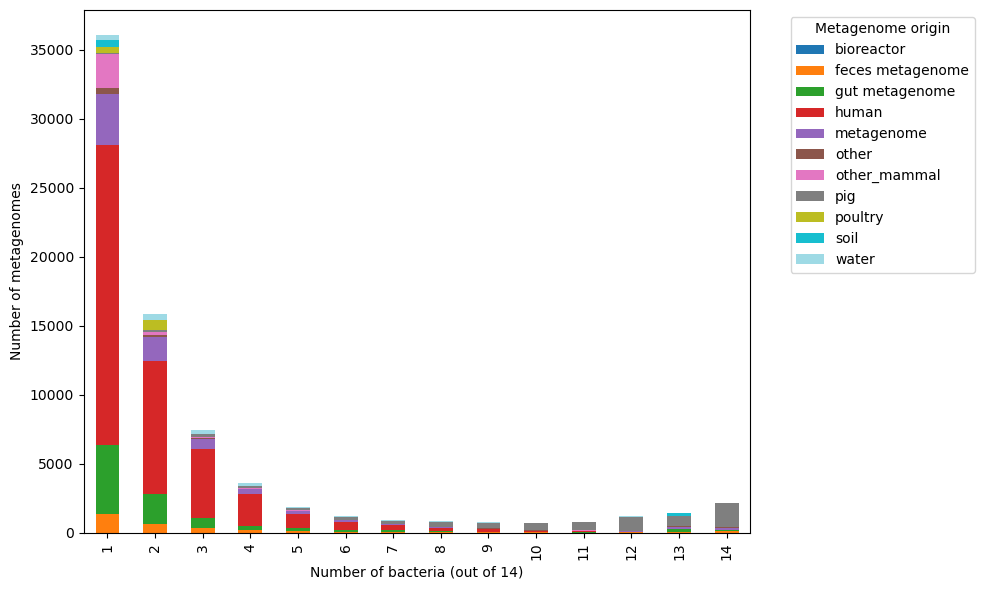

In [277]:
# make chart with absolute numbers
numeric_cols = df_grouped.select_dtypes(include='number').columns.tolist()

df_abs = df_grouped.set_index('broad_cat')[numeric_cols]
ax = df_abs.T.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
ax.set_ylabel('Number of metagenomes')
ax.set_xlabel('Number of bacteria (out of 14)')

plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.show()
plt.savefig('../plots/251001_absolute_metag.branchwater.png')


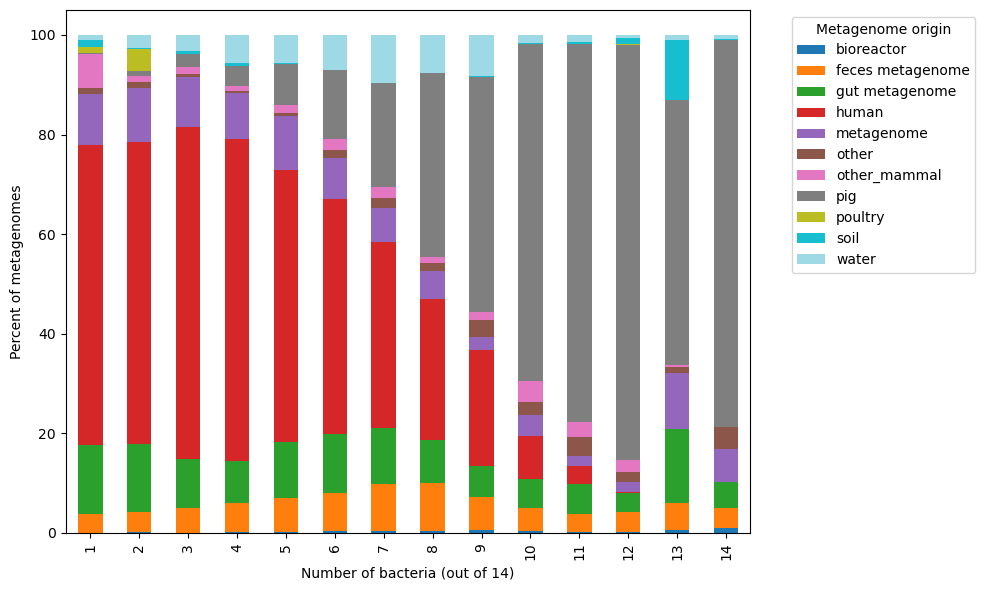

In [276]:

# Automatically select numeric columns
numeric_cols = df_grouped.select_dtypes(include='number').columns.tolist()

# Normalize each column to sum to 100%
df_norm = df_grouped.set_index('broad_cat')[numeric_cols].div(df_grouped[numeric_cols].sum(axis=0), axis=1) * 100

# Plot stacked bar chart
ax = df_norm.T.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
ax.set_ylabel('Percent of metagenomes')
ax.set_xlabel('Number of bacteria (out of 14)')
plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../plots/251001_percent_metag.branchwater.png')


In [ ]:
# simpler cats
category_map = {
    'human': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa'],
    'cow': ['cow', 'bovine', 'bos'],


# Function to assign category based on keywords
def get_broad_cat(organism):
    for cat, keywords in category_map.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  # default if no keywords match

# Apply to your DataFrame
df['broad_cat'] = df['organism'].apply(get_broad_cat)


In [156]:
df_pivot.to_csv('../../2025-pig-binning-paper/250830-branchwater/251001_branchwater.orgcount_metagenome.csv')

In [140]:
# # make smaller groups of "organims"
# bacteria = ["Anaerostipes","Actinomycetota","Bacteroides", "Bacillota","Agathobacter","Akkermansia","Alistipes",
#            "bacterium", "Escherichia","Barnesiella", "Bacteroidota", "Campylobacter", "Clostridium",
#             "Enterobacter", "coccus", "Firmicutes", "Prevotella", "Streptococ", "Candidatus Arthromitus sp. SFB-turkey",
#            "gonorrhoeae","Collinsella","Faecalitalea sp. UBA637","bacillus", "Lawsonia","Megamonas","Pseudomonadota",
#            "Roseburia", "Subdoligranulum"]
# virus = ['virus', 'Uroviricota']
# mammal_not_human = ['bos taurus', "Cervus nippon", "canis", "canine", "musculus","bovine","primate","rat",
#                    'Elaphurus davidianus', "Equus", "Felis catus", "Macaca mulatta", "Pan troglodytes",
#                    "Rusa unicolor", ]
# other_vertebrate = ['gallus']
# other = ['Caenorhabditis elegans', "Rinodina peloleuca", "Saccharomyces"]
# soil = ["sludge", 'soil', 'sediment', 'sand', 'bog']
# bioreactor = ['bioreactor', 'digester', 'fermenter']
# air = ['air', 'aerosol']
# human = ['human', 'sapiens', 'homo']
# pig = ['pig','sus','scrofa' ]

In [141]:
def group_df(df, list_org, col_name):
    mask = df['organism'].str.contains('|'.join(list_org), case=False, regex=True)
    group_sum = df.loc[mask, df.columns[1:]].sum()
    df = df.loc[~mask]
    group_row = pd.DataFrame([[col_name] + group_sum.tolist()], columns=df.columns)
    df = pd.concat([df, group_row], ignore_index=True)
    return df


In [143]:
df_pivot = group_df(df_pivot, virus, "virus")
df_pivot = group_df(df_pivot, bacteria, "bacteria")
df_pivot = group_df(df_pivot, mammal_not_human, "mammal_not_human")
df_pivot = group_df(df_pivot, other, "other")
df_pivot = group_df(df_pivot, soil, "soil")
df_pivot = group_df(df_pivot, bioreactor, "bioreactor")
df_pivot = group_df(df_pivot, air, "air")
df_pivot = group_df(df_pivot, human, "human")
df_pivot = group_df(df_pivot, pig, "pig")

In [144]:
df_pivot.to_csv('test.csv')